In [2]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

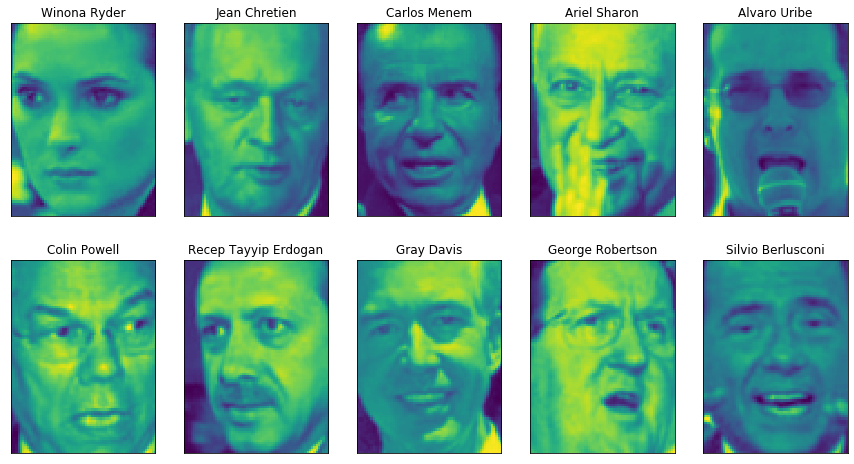

In [3]:

from sklearn.datasets import fetch_lfw_people

people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape

fix, axes = plt.subplots(2, 5, figsize=(15, 8), subplot_kw={'xticks': (), 'yticks': ()})

for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(people.target_names[target])

There are 3,023 images, each 87×65 pixels large, belonging to 62 different people:

In [4]:
print("people.images.shape: {}".format(people.images.shape))
print("Number of classes: {}".format(len(people.target_names)))

people.images.shape: (3023, 87, 65)
Number of classes: 62


The dataset is a bit skewed, however, containing a lot of images of George W. Bush
and Colin Powell, as you can see here:

In [5]:
# count how often each target appears
counts = np.bincount(people.target)

# print counts next to target names
for i, (count, name) in enumerate(zip(counts, people.target_names)):
    print("{0:25} {1:3}".format(name, count), end=' ')
    if (i + 1) % 3 == 0:
        print()

Alejandro Toledo           39 Alvaro Uribe               35 Amelie Mauresmo            21 
Andre Agassi               36 Angelina Jolie             20 Ariel Sharon               77 
Arnold Schwarzenegger      42 Atal Bihari Vajpayee       24 Bill Clinton               29 
Carlos Menem               21 Colin Powell              236 David Beckham              31 
Donald Rumsfeld           121 George Robertson           22 George W Bush             530 
Gerhard Schroeder         109 Gloria Macapagal Arroyo    44 Gray Davis                 26 
Guillermo Coria            30 Hamid Karzai               22 Hans Blix                  39 
Hugo Chavez                71 Igor Ivanov                20 Jack Straw                 28 
Jacques Chirac             52 Jean Chretien              55 Jennifer Aniston           21 
Jennifer Capriati          42 Jennifer Lopez             21 Jeremy Greenstock          24 
Jiang Zemin                20 John Ashcroft              53 John Negroponte            31 

To make the data less skewed, we will only take up to 50 images of each person
(otherwise, the feature extraction would be overwhelmed by the likelihood of George
W. Bush):

In [6]:
mask = np.zeros(people.target.shape, dtype=np.bool)

for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1

X_people = people.data[mask]
y_people = people.target[mask]

# scale the grayscale values to be between 0 and 1
# instead of 0 and 255 for better numeric stability
X_people = X_people / 255.

A simple solution is to use a one-nearest-neighbor classifier that looks for the most
similar face image to the face you are classifying. This classifier could in principle
work with only a single training example per class. Let’s take a look at how well
KNeighborsClassifier does here:

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
X_people, y_people, stratify=y_people, random_state=0)

# build a KNeighborsClassifier using one neighbor
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

print("Test set score of 1-nn: {:.2f}".format(knn.score(X_test, y_test)))

Test set score of 1-nn: 0.23


We obtain an accuracy of 23%, which is not actually that bad for a 62-class classification
problem (random guessing would give you around 1/62 = 1.5% accuracy), but
is also not great. We only correctly identify a person every fourth time.

This is where PCA comes in. Computing distances in the original pixel space is quite
a bad way to measure similarity between faces. When using a pixel representation to
compare two images, we compare the grayscale value of each individual pixel to the
value of the pixel in the corresponding position in the other image. This representation
is quite different from how humans would interpret the image of a face, and it is
hard to capture the facial features using this raw representation. For example, using
pixel distances means that shifting a face by one pixel to the right corresponds to a
drastic change, with a completely different representation. We hope that using distances
along principal components can improve our accuracy. Here, we enable the
whitening option of PCA, which rescales the principal components to have the same
scale. This is the same as using StandardScaler after the transformation. Reusing the
data from Figure 3-3 again, whitening corresponds to not only rotating the data, but
also rescaling it so that the center panel is a circle instead of an ellipse

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100, whiten=True, random_state=0).fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("X_train_pca.shape: {}".format(X_train_pca.shape))

X_train_pca.shape: (1547, 100)


Now, we can use
the new representation to classify our images using a one-nearest-neighbors classifier:

In [9]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_pca, y_train)
print("Test set accuracy: {:.2f}".format(knn.score(X_test_pca, y_test)))

Test set accuracy: 0.31


Our accuracy improved quite significantly, from 26.6% to 35.7%, confirming our
intuition that the principal components might provide a better representation of the
data.

For image data, we can also easily visualize the principal components that are found.
Remember that components correspond to directions in the input space. The input
space here is 50×37-pixel grayscale images, so directions within this space are also
50×37-pixel grayscale images.
Let’s look at the first couple of principal components

In [10]:
print("pca.components_.shape: {}".format(pca.components_.shape))

pca.components_.shape: (100, 5655)


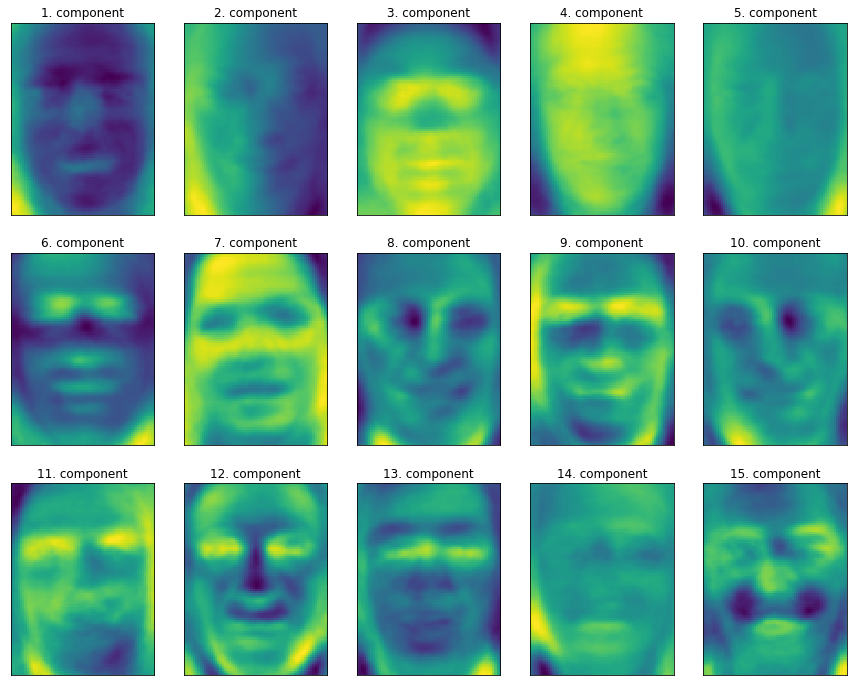

In [11]:
fix, axes = plt.subplots(3, 5, figsize=(15, 12),
                                        subplot_kw={'xticks': (), 'yticks': ()})

for i, (component, ax) in enumerate(zip(pca.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape),
                cmap='viridis')
    ax.set_title("{}. component".format((i + 1)))

## Non-negative matrix factorization NMF

another unsupervised learning algorithm that
aims to extract useful features. It works similarly to PCA and can also be used for
dimensionality reduction.

As a first look into the data, let’s try extracting only a few components

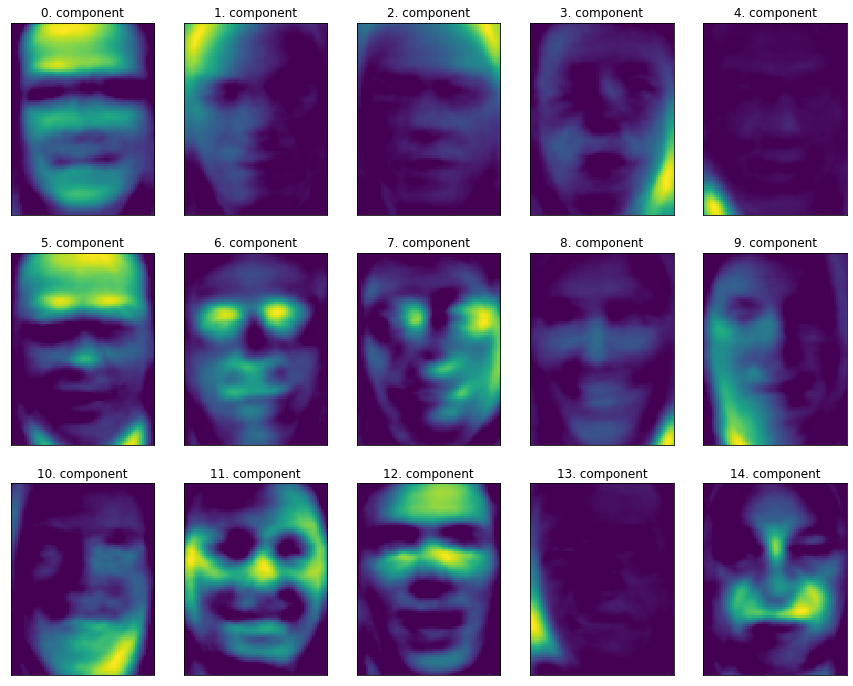

In [12]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=15, random_state=0)
nmf.fit(X_train)

X_train_nmf = nmf.transform(X_train)
X_test_nmf = nmf.transform(X_test)

fix, axes = plt.subplots(3, 5, figsize=(15, 12),
subplot_kw={'xticks': (), 'yticks': ()})

for i, (component, ax) in enumerate(zip(nmf.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("{}. component".format(i))

These components are all positive, and so resemble prototypes of faces much more so than the components shown for PCA.

For example, one can clearly see
that component 3 shows a face rotated somewhat to the right, while component 7
shows a face somewhat rotated to the left. Let’s look at the images for which these
components are particularly strong

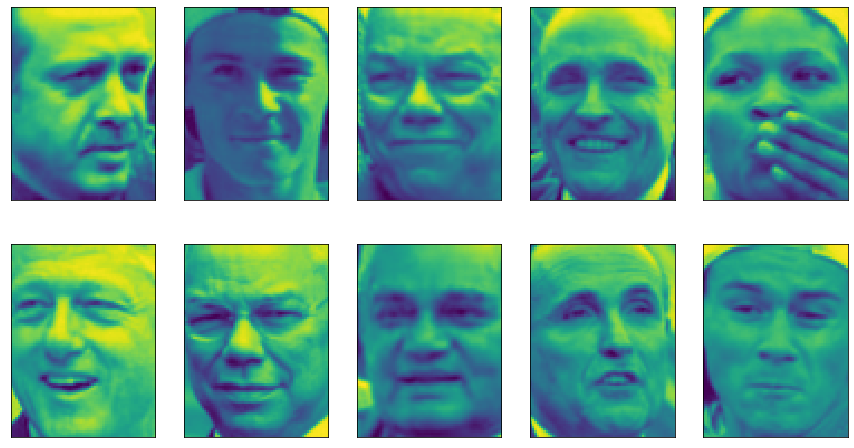

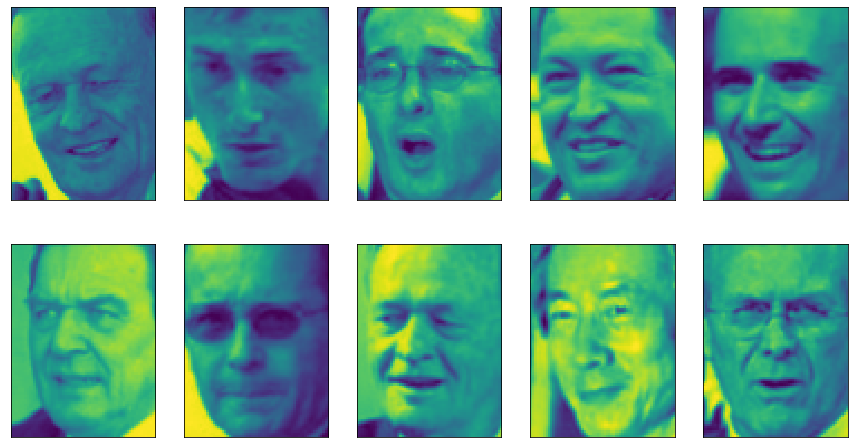

In [13]:
compn = 2

# sort by 3rd component, plot first 10 images
inds = np.argsort(X_train_nmf[:, compn])[::-1]
fig, axes = plt.subplots(2, 5, figsize=(15, 8),
                            subplot_kw={'xticks': (), 'yticks': ()})
for i, (ind, ax) in enumerate(zip(inds, axes.ravel())):
    ax.imshow(X_train[ind].reshape(image_shape))

compn = 13

# sort by 7th component, plot first 10 images
inds = np.argsort(X_train_nmf[:, compn])[::-1]
fig, axes = plt.subplots(2, 5, figsize=(15, 8),
                            subplot_kw={'xticks': (), 'yticks': ()})
for i, (ind, ax) in enumerate(zip(inds, axes.ravel())):
    ax.imshow(X_train[ind].reshape(image_shape))

As expected, faces that have a high coefficient for component 3 are faces looking to
the right, while faces with a high coefficient for component 7 are looking
to the left. As mentioned earlier, extracting patterns like these works
best for data with additive structure, including audio, gene expression, and text data.

## Manifold Learning with t-SNE

Manifold learning algorithms are mainly aimed at visualization, and so are rarely
used to generate more than two new features. Some of them, including t-SNE, compute
a new representation of the training data, but don’t allow transformations of new
data. This means these algorithms cannot be applied to a test set: rather, they can only
transform the data they were trained for. Manifold learning can be useful for exploratory
data analysis, but is rarely used if the final goal is supervised learning.

We will apply the t-SNE manifold learning algorithm on a dataset of handwritten digits
that is included in scikit-learn.2 Each data point in this dataset is an 8×8 grayscale
image of a handwritten digit between 0 and 1.

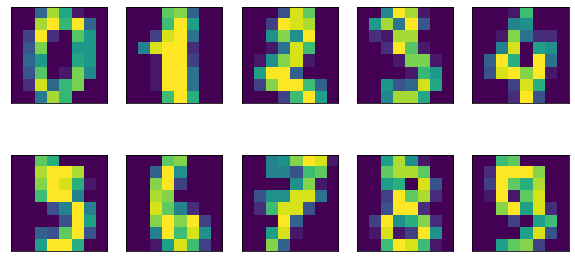

In [14]:
from sklearn.datasets import load_digits

digits = load_digits()
fig, axes = plt.subplots(2, 5, figsize=(10, 5),
                            subplot_kw={'xticks':(), 'yticks': ()})

for ax, img in zip(axes.ravel(), digits.images):
    ax.imshow(img)

Let’s use PCA to visualize the data reduced to two dimensions. We plot the first two
principal components, and color each dot by its class

Text(0, 0.5, 'Second principal component')

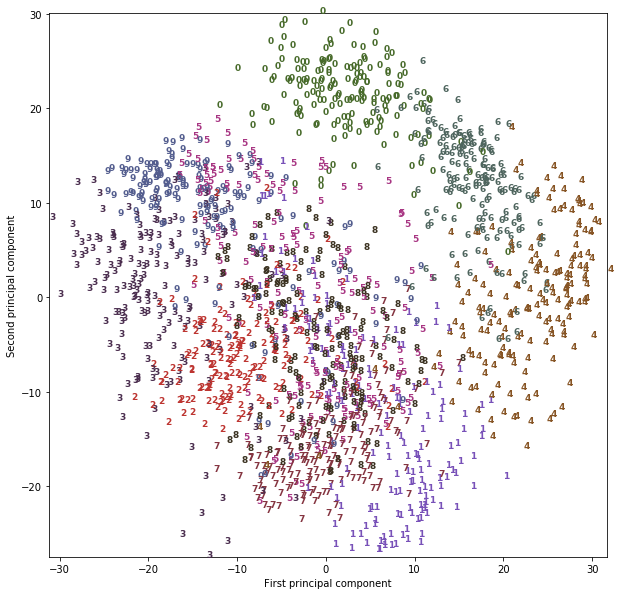

In [15]:
# build a PCA model
pca = PCA(n_components=2)
pca.fit(digits.data)

# transform the digits data onto the first two principal components
digits_pca = pca.transform(digits.data)
colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
            "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]

plt.figure(figsize=(10, 10))
plt.xlim(digits_pca[:, 0].min(), digits_pca[:, 0].max())
plt.ylim(digits_pca[:, 1].min(), digits_pca[:, 1].max())

for i in range(len(digits.data)):
    # actually plot the digits as text instead of using scatter
    plt.text(digits_pca[i, 0], digits_pca[i, 1], str(digits.target[i]),
                color = colors[digits.target[i]],
                fontdict={'weight': 'bold', 'size': 9})

plt.xlabel("First principal component")
plt.ylabel("Second principal component")

Here, we actually used the true digit classes as glyphs, to show which class is where.
The digits zero, six, and four are relatively well separated using the first two principal
components, though they still overlap. Most of the other digits overlap significantly

Let’s apply t-SNE to the same dataset, and compare the results. As t-SNE does not
support transforming new data, the TSNE class has no transform method. Instead, we
can call the fit_transform method, which will build the model and immediately
return the transformed data

Text(0.5, 0, 't-SNE feature 1')

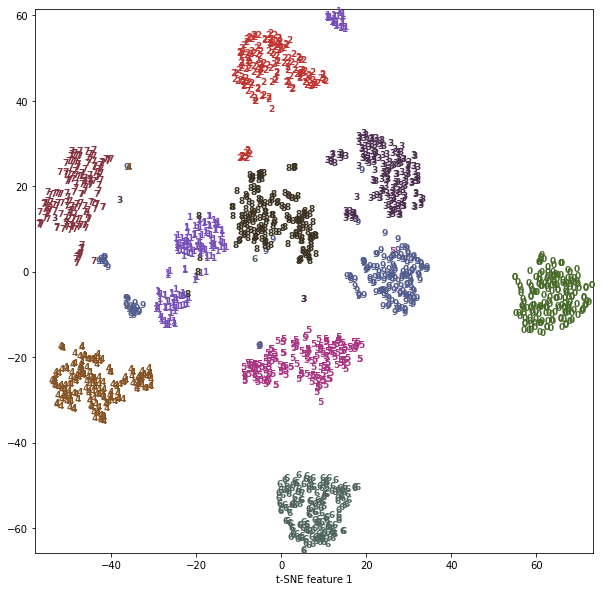

In [16]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=42)

# use fit_transform instead of fit, as TSNE has no transform method
digits_tsne = tsne.fit_transform(digits.data)

plt.figure(figsize=(10, 10))
plt.xlim(digits_tsne[:, 0].min(), digits_tsne[:, 0].max() + 1)
plt.ylim(digits_tsne[:, 1].min(), digits_tsne[:, 1].max() + 1)

for i in range(len(digits.data)):
    # actually plot the digits as text instead of using scatter
    plt.text(digits_tsne[i, 0], digits_tsne[i, 1], str(digits.target[i]),
                color = colors[digits.target[i]],
                fontdict={'weight': 'bold', 'size': 9})

plt.xlabel("t-SNE feature 0")
plt.xlabel("t-SNE feature 1")

The result of t-SNE is quite remarkable. All the classes are quite clearly separated.
The ones and nines are somewhat split up, but most of the classes form a single dense
group. Keep in mind that this method has no knowledge of the class labels: it is completely
unsupervised. Still, it can find a representation of the data in two dimensions
that clearly separates the classes, based solely on how close points are in the original
space.

## Clustering

The goal is to split up the data in such a way that points within a single
cluster are very similar and points in different clusters are different.

k-Means Clustering

k-means clustering is one of the simplest and most commonly used clustering algorithms.
It tries to find cluster centers that are representative of certain regions of the
data. The algorithm alternates between two steps: assigning each data point to the
closest cluster center, and then setting each cluster center as the mean of the data
points that are assigned to it. The algorithm is finished when the assignment of
instances to clusters no longer changes.

Even if you know the “right” number of clusters for a given dataset, k-means might
not always be able to recover them. Each cluster is defined solely by its center, which
means that each cluster is a convex shape. As a result of this, k-means can only capture
relatively simple shapes. k-means also assumes that all clusters have the same
“diameter” in some sense; it always draws the boundary between clusters to be exactly
in the middle between the cluster centers. That can sometimes lead to surprising
results,

k-means, on the other hand, tries to represent
each data point using a cluster center. You can think of that as each point being
represented using only a single component, which is given by the cluster center. This
view of k-means as a decomposition method, where each point is represented using a
single component, is called vector quantization.

Let’s do a side-by-side comparison of PCA, NMF, and k-means, showing the components
extracted, as well as reconstructions of faces from the test set
using 100 components. For k-means, the reconstruction is the closest
cluster center found on the training set:

In [17]:
from sklearn.cluster import KMeans

X_train, X_test, y_train, y_test = train_test_split(
    X_people, y_people, stratify=y_people, random_state=0)

nmf = NMF(n_components=100, random_state=0)
nmf.fit(X_train)

pca = PCA(n_components=100, random_state=0)
pca.fit(X_train)

kmeans = KMeans(n_clusters=100, random_state=0)
kmeans.fit(X_train)

X_reconstructed_pca = pca.inverse_transform(pca.transform(X_test))
X_reconstructed_kmeans = kmeans.cluster_centers_[kmeans.predict(X_test)]
X_reconstructed_nmf = np.dot(nmf.transform(X_test), nmf.components_)

Text(0, 0.5, 'nmf')

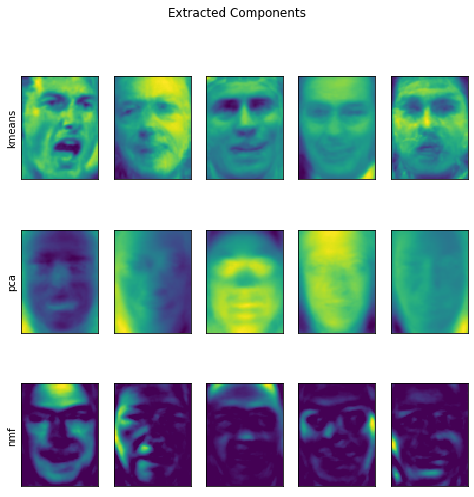

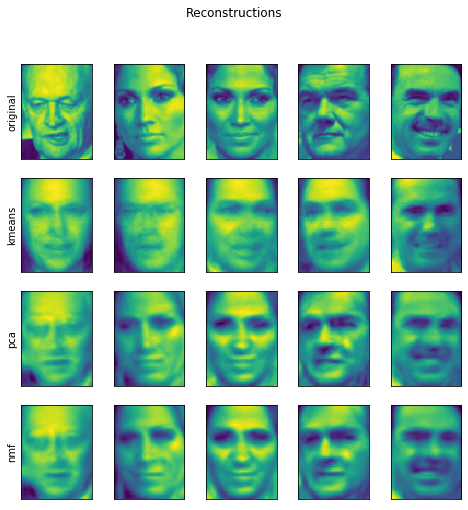

In [18]:
fig, axes = plt.subplots(3, 5, figsize=(8, 8),
            subplot_kw={'xticks': (), 'yticks': ()})
fig.suptitle("Extracted Components")

for ax, comp_kmeans, comp_pca, comp_nmf in zip(
            axes.T, kmeans.cluster_centers_, pca.components_, nmf.components_):
    ax[0].imshow(comp_kmeans.reshape(image_shape))
    ax[1].imshow(comp_pca.reshape(image_shape), cmap='viridis')
    ax[2].imshow(comp_nmf.reshape(image_shape))

axes[0, 0].set_ylabel("kmeans")
axes[1, 0].set_ylabel("pca")
axes[2, 0].set_ylabel("nmf")

fig, axes = plt.subplots(4, 5, subplot_kw={'xticks': (), 'yticks': ()},
                        figsize=(8, 8))
fig.suptitle("Reconstructions")

for ax, orig, rec_kmeans, rec_pca, rec_nmf in zip(
                    axes.T, X_test, X_reconstructed_kmeans, X_reconstructed_pca,
                    X_reconstructed_nmf):
    ax[0].imshow(orig.reshape(image_shape))
    ax[1].imshow(rec_kmeans.reshape(image_shape))
    ax[2].imshow(rec_pca.reshape(image_shape))
    ax[3].imshow(rec_nmf.reshape(image_shape))

axes[0, 0].set_ylabel("original")
axes[1, 0].set_ylabel("kmeans")
axes[2, 0].set_ylabel("pca")
axes[3, 0].set_ylabel("nmf")

## Comparing and Evaluating Clustering Algorithms

One of the challenges in applying clustering algorithms is that it is very hard to assess
how well an algorithm worked, and to compare outcomes between different algorithms.
After talking about the algorithms behind k-means, agglomerative clustering,
and DBSCAN, we will now compare them on some real-world datasets.

Let’s apply the k-means, DBSCAN, and agglomerative clustering algorithms to the
Labeled Faces in the Wild dataset, and see if any of them find interesting structure.
We will use the eigenface representation of the data, as produced by
PCA(whiten=True), with 100 components:

In [20]:
# extract eigenfaces from lfw data and transform data
from sklearn.decomposition import PCA

pca = PCA(n_components=100, whiten=True, random_state=0)
pca.fit_transform(X_people)
X_pca = pca.transform(X_people)

Analyzing the faces dataset with DBSCAN.

In [22]:
from sklearn.cluster import DBSCAN
# apply DBSCAN with default parameters
dbscan = DBSCAN()
labels = dbscan.fit_predict(X_pca)
print("Unique labels: {}".format(np.unique(labels)))

Unique labels: [-1]


We see that all the returned labels are –1, so all of the data was labeled as “noise” by
DBSCAN.

Let’s try changing min_samples first:

In [23]:
dbscan = DBSCAN(min_samples=3)
labels = dbscan.fit_predict(X_pca)
print("Unique labels: {}".format(np.unique(labels)))

Unique labels: [-1]


To understand better what’s happening, let’s look at how many points are noise, and
how many points are inside the cluster:

In [24]:
# Count number of points in all clusters and noise.
# bincount doesn't allow negative numbers, so we need to add 1.
# The first number in the result corresponds to noise points.
print("Number of points per cluster: {}".format(np.bincount(labels + 1)))

Number of points per cluster: [2063]


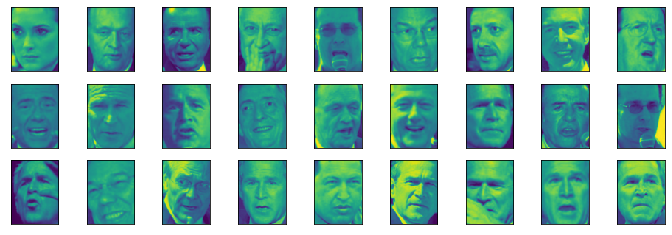

In [26]:
noise = X_people[labels==-1]
fig, axes = plt.subplots(3, 9, subplot_kw={'xticks': (), 'yticks': ()},
                        figsize=(12, 4))
for image, ax in zip(noise, axes.ravel()):
    ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)

Comparing these images to the random sample of face images from Figure 3-7, we
can guess why they were labeled as noise: the fifth image in the first row shows a person
drinking from a glass, there are images of people wearing hats, and in the last
image there’s a hand in front of the person’s face. The other images contain odd angles
or crops that are too close or too wide.

If we want to find more interesting clusters than just one large one, we need to set eps
smaller, somewhere between 15 and 0.5 (the default). Let’s have a look at what different
values of eps result in:

In [27]:
for eps in [1, 3, 5, 7, 9, 11, 13]:
    print("\neps={}".format(eps))
    dbscan = DBSCAN(eps=eps, min_samples=3)
    labels = dbscan.fit_predict(X_pca)
    print("Clusters present: {}".format(np.unique(labels)))
    print("Cluster sizes: {}".format(np.bincount(labels + 1)))


eps=1
Clusters present: [-1]
Cluster sizes: [2063]

eps=3
Clusters present: [-1]
Cluster sizes: [2063]

eps=5
Clusters present: [-1]
Cluster sizes: [2063]

eps=7
Clusters present: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12]
Cluster sizes: [2004    3   14    7    4    3    3    4    4    3    3    5    3    3]

eps=9
Clusters present: [-1  0  1  2]
Cluster sizes: [1307  750    3    3]

eps=11
Clusters present: [-1  0]
Cluster sizes: [ 413 1650]

eps=13
Clusters present: [-1  0]
Cluster sizes: [ 120 1943]


The results for eps=7 look most interesting, with many small clusters. We can investigate
this clustering in more detail by visualizing all of the points in each of the 13
small clusters

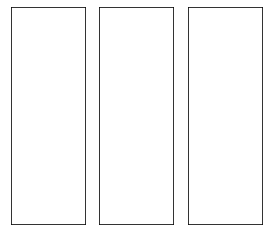

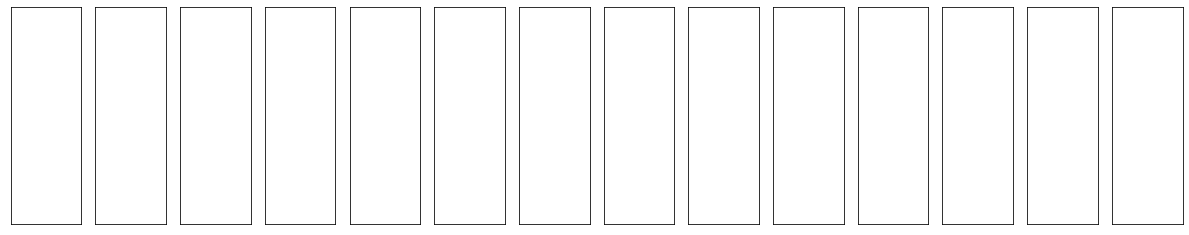

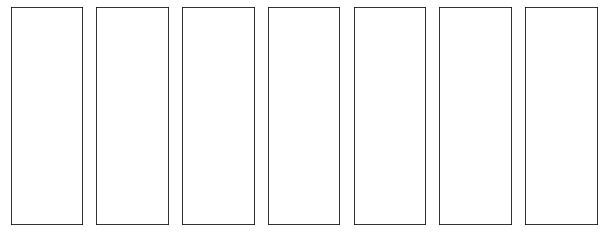

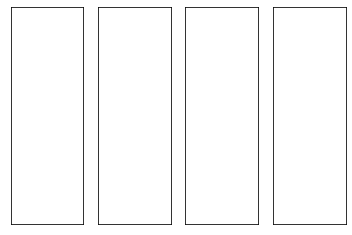

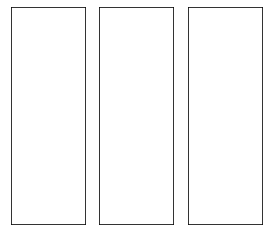

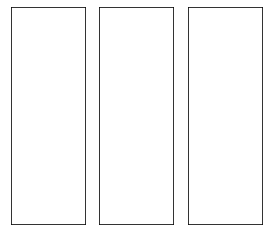

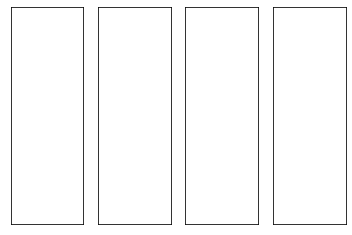

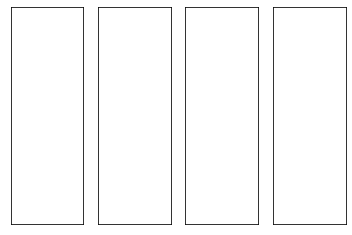

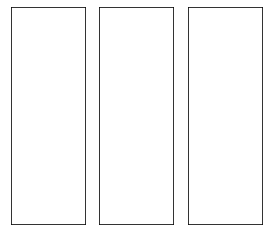

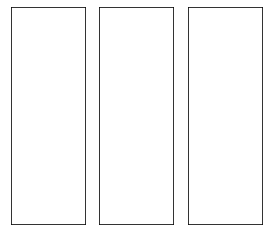

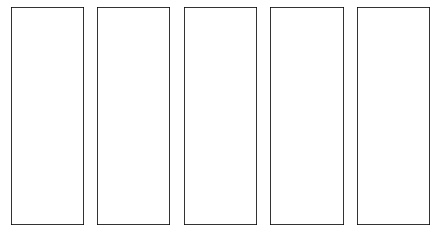

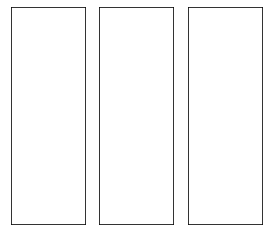

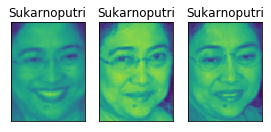

In [29]:
dbscan = DBSCAN(min_samples=3, eps=7)
labels = dbscan.fit_predict(X_pca)

for cluster in range(max(labels) + 1):
    mask = labels == cluster
    n_images = np.sum(mask)
    fig, axes = plt.subplots(1, n_images, figsize=(n_images * 1.5, 4),
                            subplot_kw={'xticks': (), 'yticks': ()})

for image, label, ax in zip(X_people[mask], y_people[mask], axes):
    ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
    ax.set_title(people.target_names[label].split()[-1])

This concludes our analysis of the DBSCAN algorithm applied to the faces dataset. As
you can see, we are doing a manual analysis here, different from the much more automatic
search approach we could use for supervised learning based on R2 score or
accuracy.

Analyzing the faces dataset with k-means

Agglomerative clustering and k-means are
much more likely to create clusters of even size, but we do need to set a target number
of clusters. We could set the number of clusters to the known number of people in
the dataset, though it is very unlikely that an unsupervised clustering algorithm will
recover them. Instead, we can start with a low number of clusters, like 10, which
might allow us to analyze each of the clusters:

In [31]:
# extract clusters with k-means
km = KMeans(n_clusters=10, random_state=0)
labels_km = km.fit_predict(X_pca)
print("Cluster sizes k-means: {}".format(np.bincount(labels_km)))

Cluster sizes k-means: [155 175 238  75 358 257  91 219 323 172]


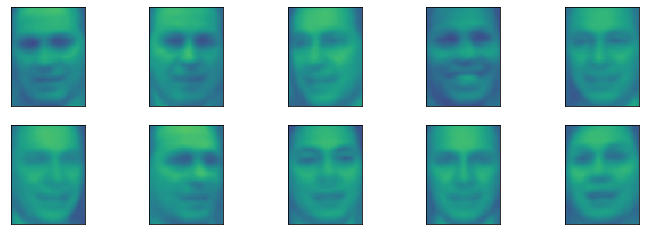

In [33]:
fig, axes = plt.subplots(2, 5, subplot_kw={'xticks': (), 'yticks': ()},
                        figsize=(12, 4))
for center, ax in zip(km.cluster_centers_, axes.ravel()):
    ax.imshow(pca.inverse_transform(center).reshape(image_shape),
                    vmin=0, vmax=1)

The cluster centers found by k-means are very smooth versions of faces. This is not
very surprising, given that each center is an average of 64 to 386 face images. Working
with a reduced PCA representation adds to the smoothness of the images (compared
to the faces reconstructed using 100 PCA dimensions.

Analyzing the faces dataset with agglomerative clustering.

In [35]:
from sklearn.cluster import AgglomerativeClustering

# extract clusters with ward agglomerative clustering
agglomerative = AgglomerativeClustering(n_clusters=10)
labels_agg = agglomerative.fit_predict(X_pca)
print("Cluster sizes agglomerative clustering: {}".format(
        np.bincount(labels_agg)))

Cluster sizes agglomerative clustering: [169 660 144 329 217  85  18 261  31 149]


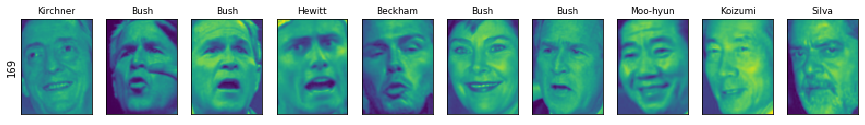

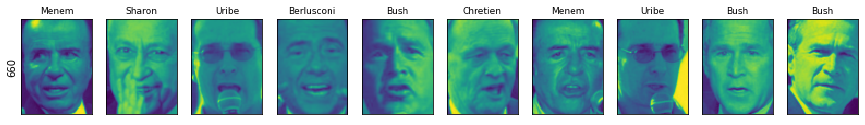

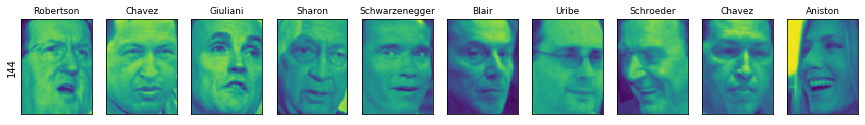

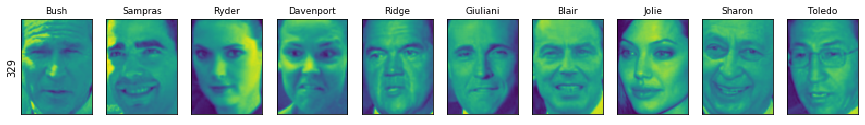

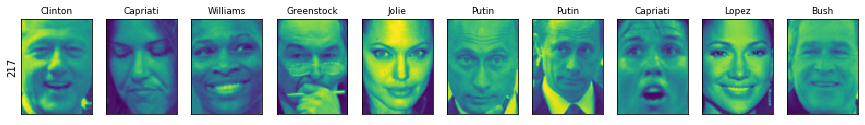

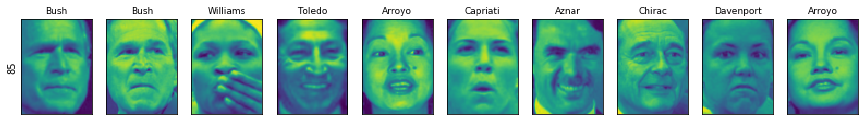

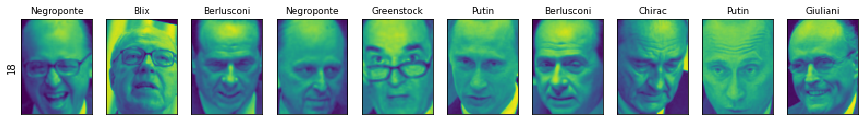

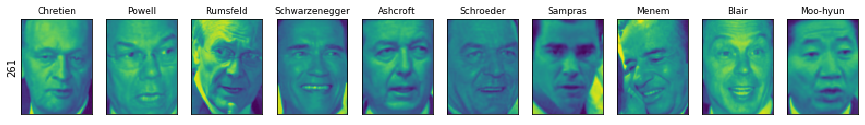

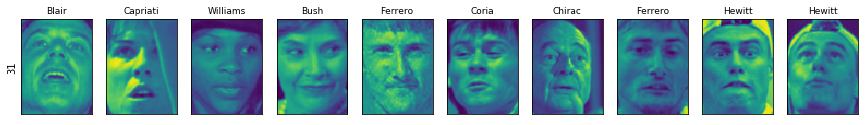

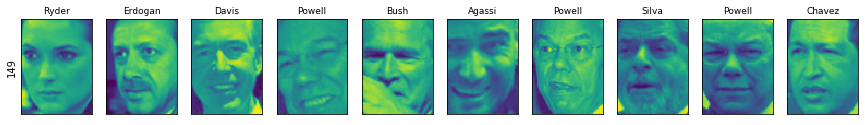

In [36]:
n_clusters = 10
for cluster in range(n_clusters):
    mask = labels_agg == cluster
    fig, axes = plt.subplots(1, 10, subplot_kw={'xticks': (), 'yticks': ()},
                            figsize=(15, 8))
    axes[0].set_ylabel(np.sum(mask))
    for image, label, asdf, ax in zip(X_people[mask], y_people[mask],
                                        labels_agg[mask], axes):
        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
        ax.set_title(people.target_names[label].split()[-1],
                        fontdict={'fontsize': 9})

While some of the clusters seem to have a semantic theme, many of them are too
large to be actually homogeneous. To get more homogeneous clusters, we can run the
algorithm again, this time with 40 clusters, and pick out some of the clusters that are
particularly interesting

cluster sizes agglomerative clustering: [ 43 120 100 194  56  58 127  22   6  37  65  49  84  18 168  44  47  31
  78  30 166  20  57  14  11  29  23   5   8  84  67  30  57  16  22  12
  29   2  26   8]


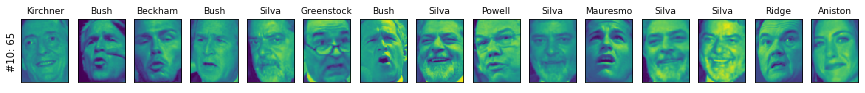

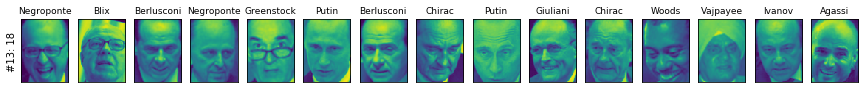

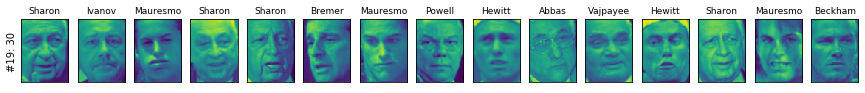

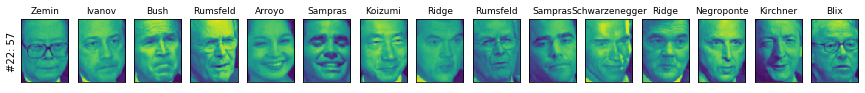

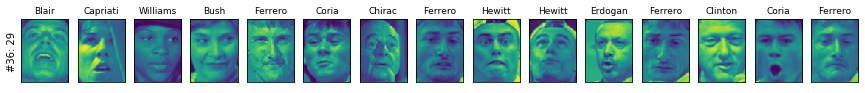

In [37]:
# extract clusters with ward agglomerative clustering
agglomerative = AgglomerativeClustering(n_clusters=40)
labels_agg = agglomerative.fit_predict(X_pca)
print("cluster sizes agglomerative clustering: {}".format(np.bincount(labels_agg)))

n_clusters = 40
for cluster in [10, 13, 19, 22, 36]: # hand-picked "interesting" clusters
    mask = labels_agg == cluster
    fig, axes = plt.subplots(1, 15, subplot_kw={'xticks': (), 'yticks': ()},
                            figsize=(15, 8))
    cluster_size = np.sum(mask)
    axes[0].set_ylabel("#{}: {}".format(cluster, cluster_size))
    for image, label, asdf, ax in zip(X_people[mask], y_people[mask],
                                        labels_agg[mask], axes):
        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
        ax.set_title(people.target_names[label].split()[-1],
                    fontdict={'fontsize': 9})
    for i in range(cluster_size, 15):
        axes[i].set_visible(False)